In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Torchvision module contains various utilities, classes, models and datasets 
# used towards computer vision usecases
from torchvision import datasets
from torchvision import transforms

# Functional module contains helper functions
import torch.nn.functional as F

In [2]:
# Mean and standard deviation of all the pixels in the FMNIST dataset
# It is 0.5 since these are PIL images
mean_gray = 0.5
stddev_gray = 0.5

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean_gray,), (stddev_gray,))])

fmnist_train = datasets.FashionMNIST('./data.fmnist', train=True, download=True, transform=transform)
fmnist_valid = datasets.FashionMNIST('./data.fmnist', train=False, download=True, transform=transform)

**The classes and their labels**

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot 


In [3]:
example_id = 15

In [4]:
img = fmnist_train[example_id][0].numpy() * stddev_gray + mean_gray

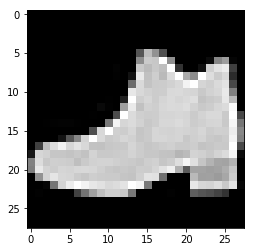

In [5]:
plt.imshow(img.reshape(28, 28), cmap='gray')
# Note that each image is 28 x 28 pixel

In [6]:
label = fmnist_train[example_id][1]
label

9

In [7]:
batch_size = 1000 # Reduce this if you get out-of-memory error

In [8]:
fmnist_train_loader = torch.utils.data.DataLoader(fmnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
fmnist_valid_loader = torch.utils.data.DataLoader(fmnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

https://github.com/GunhoChoi/Kind-PyTorch-Tutorial/blob/master/07_Denoising_Autoencoder/Denoising_Autoencoder.ipynb

In [9]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 12544)
        return out


In [10]:

# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# batch x 512 -> batch x 1 x 28 x 28

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(-1,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out


In [11]:
class Encoder(nn.Module):
    def __init__(self):
        
        super(Encoder,self).__init__()
                                             # 28 x 28 x 1  (input)
        self.thelayers = nn.Sequential(
            nn.Conv2d(1, 24, 3),             # 26 x 26 x 24
            nn.ReLU(),
            nn.Conv2d(24, 48, 3),            # 24 x 24 x 48
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 12 x 12 x 48
        )
                
    def forward(self,x):
        out = self.thelayers(x)
        out = out.view(-1, 6912)
        return out
    


In [12]:
class Decoder(nn.Module):
    
    def __init__(self):
    
        super(Decoder, self).__init__()
        
        self.thelayers = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 5),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 5),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 6, 5),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 1, 5),
            nn.ReLU(),
        )
        
    def forward(self, x):
        out = x.view(-1, 48, 12, 12)
        out = self.thelayers(out)
        return out

In [13]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()

In [14]:
for image,label in fmnist_train_loader:
    image = Variable(image).cuda()
    
    output = encoder(image)
    output = decoder(output)
    print(output.size())
    break

torch.Size([1000, 1, 28, 28])


In [15]:
learning_rate = 0.001

In [16]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()

In [17]:
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

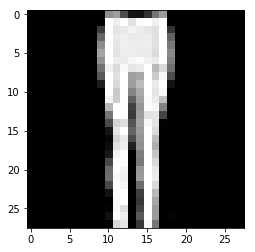

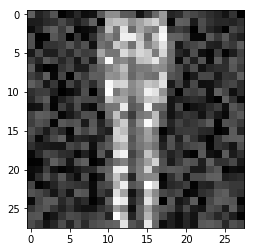

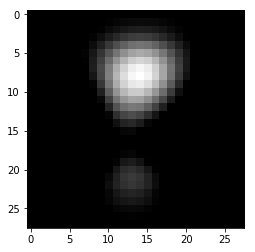

Variable containing:
 0.6343
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 0


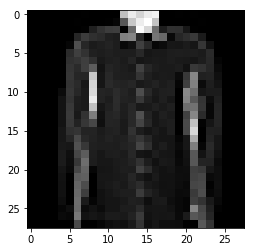

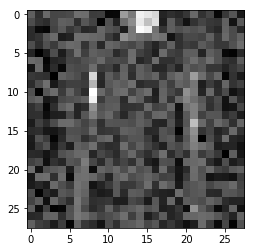

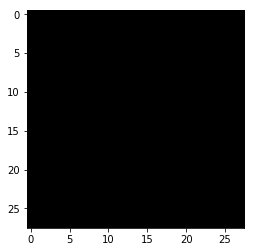

Variable containing:
 0.6129
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 1


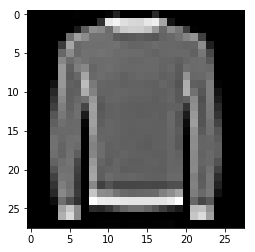

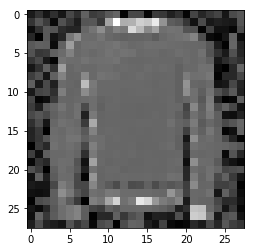

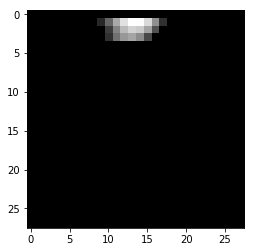

Variable containing:
 0.6042
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 2


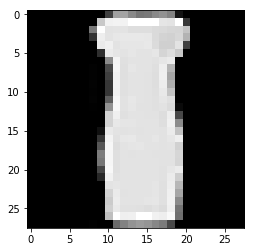

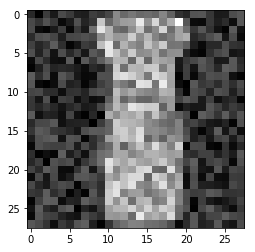

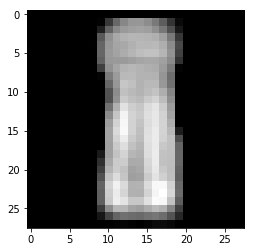

Variable containing:
 0.6043
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 3


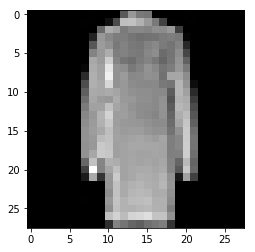

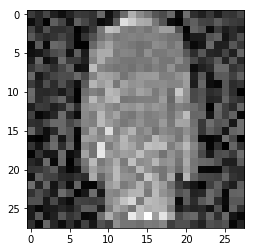

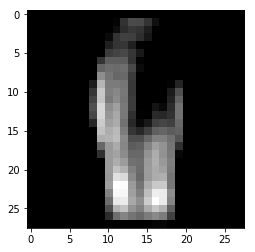

Variable containing:
 0.6053
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 4


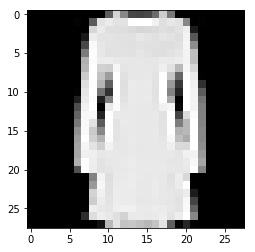

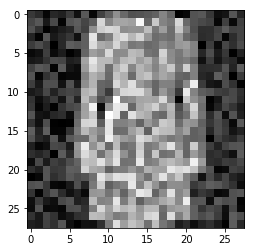

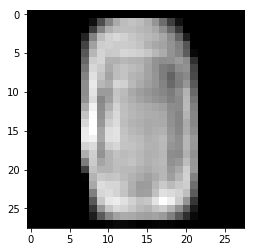

Variable containing:
 0.5985
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 5


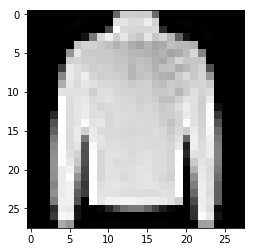

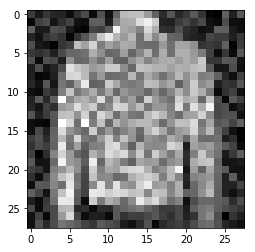

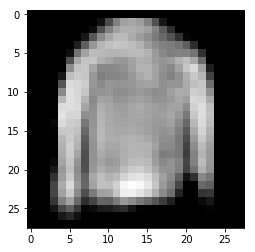

Variable containing:
 0.5993
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 6


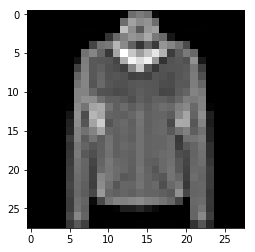

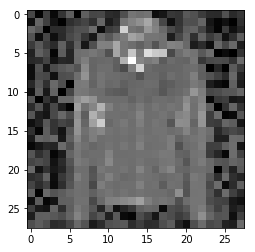

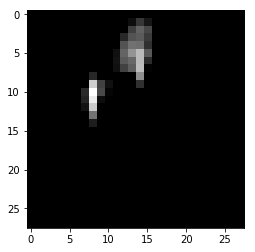

Variable containing:
 0.6008
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 7


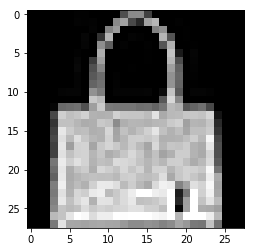

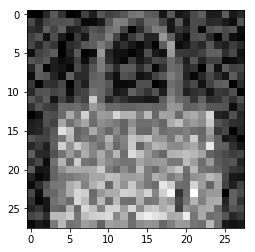

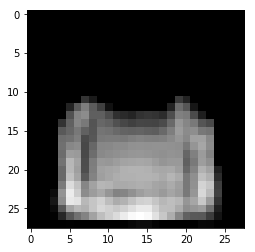

Variable containing:
 0.6031
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 8


In [ ]:
for i in range(40):
    for image,label in fmnist_train_loader:
        
        noise = torch.rand(batch_size,1,28,28)
        #image_n = torch.mul(image, noise)
        image_n = torch.mul(image+0.25, noise * 0.1)
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
        #label = Variable(label.float()).cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
    
    # check image with noise and denoised image\n# Better image if you train more or upgrade the model\n
    img = image[0].cpu()
    input_img = image_n[0].cpu()
    output_img = output[0].cpu()

    origin = img.data.numpy()
    inp = input_img.data.numpy()
    out = output_img.data.numpy()

    plt.imshow(origin[0],cmap='gray')
    plt.show()

    plt.imshow(inp[0],cmap='gray')
    plt.show()

    plt.imshow(out[0],cmap="gray")
    plt.show()

    print(loss, i)




In [ ]:
# check image with noise and denoised image\n# Better image if you train more or upgrade the model\n
img = image[0].cpu()
input_img = image_n[0].cpu()
output_img = output[0].cpu()

origin = img.data.numpy()
inp = input_img.data.numpy()
out = output_img.data.numpy()

plt.imshow(origin[0],cmap='gray')
plt.show()

plt.imshow(inp[0],cmap='gray')
plt.show()

plt.imshow(out[0],cmap="gray")
plt.show()


print(label[0])

In [ ]:
import random

In [ ]:
test_idx = random.choice(range(0, 9999))
image = fmnist_valid.test_data[test_idx].numpy().reshape(1,1,28,28)
image = torch.FloatTensor(image)
noise_n = noise[0] # torch.rand(1,1,28,28)
image_n = torch.mul(image+0.25, noise_n * 0.1)


image = Variable(image).cuda()
image_n = Variable(image_n).cuda()

#image.data.cpu().numpy().shape

output = encoder(image_n)
output = decoder(output)

#image

plt.imshow(image.data.cpu().numpy().reshape((28, 28)), cmap='gray')
plt.show()
plt.imshow(image_n.data.cpu().numpy().reshape((28, 28)), cmap='gray')
plt.show()
plt.imshow(output.data.cpu().numpy().reshape((28, 28)), cmap='gray')
plt.show()
